In [238]:
import pandas as pd

df = pd.read_csv('resources/CO2Emissions_Canada.csv')
df.drop_duplicates()
df

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


In [239]:
#encoding categorical data
from sklearn.preprocessing import LabelEncoder

numdata = pd.DataFrame(df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
                           'CO2 Emissions(g/km)']])

label_encoder = LabelEncoder()

vehicle_class = df[['Vehicle Class']].values.ravel()
fuel_type = df[['Fuel Type']].values.ravel()
transmission = df[['Transmission']].values.ravel()

encoded_vehicle_class = label_encoder.fit_transform(vehicle_class)
encoded_fuel_type = label_encoder.fit_transform(fuel_type)
encoded_transmission = label_encoder.fit_transform(transmission)

print(encoded_vehicle_class)
print(encoded_fuel_type)
print(encoded_transmission)

[ 0  0  0 ... 11 12 12]
[4 4 4 ... 4 4 4]
[14 25 22 ... 17 17 17]


In [240]:
X = numdata[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']]
X['Vehicle Class'] = encoded_vehicle_class
X['Transmission'] = encoded_fuel_type
X['Fuel Type'] = encoded_transmission
feature_names = X.columns


y = numdata[['CO2 Emissions(g/km)']].values.ravel()

In [241]:
import seaborn as sns

def getMetrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'*****************')
    print(f'Метрики качества:')
    print(f'*****************')
    print(f'MAE: {mae:.10f}')
    print(f'MSE: {mse:.10f}')
    print(f'RMSE: {rmse:.10f}')
    print(f'R²: {r2:.10f}')
    
    # Визуализация предсказанных и фактических значений
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Фактические значения')
    plt.scatter(range(len(y_test)), y_pred, color='red', label='Предсказанные значения')
    plt.xlabel('Наблюдение')
    plt.ylabel('Значение')
    plt.title('Фактические и предсказанные значения')
    plt.legend()
    plt.show()

    return (mae, mse, rmse, r2)


def getImportances(importances):
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')
    plt.title('Важность признаков')
    plt.xlabel('Важность')
    plt.ylabel('Признак')
    plt.show()

def getRemains(y_test, y_pred):
    # 13. График остатков
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30, color='orange')
    plt.title('Распределение остатков')
    plt.xlabel('Остаток (Target - Предсказание)')
    plt.ylabel('Частота')
    plt.show()
    
    # 14. Остатки vs Предсказанные значения
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('Остатки vs Предсказанные значения')
    plt.show()

*****************
Метрики качества:
*****************
MAE: 1.7462856087
MSE: 7.8869731497
RMSE: 2.8083755357
R²: 0.9977070269


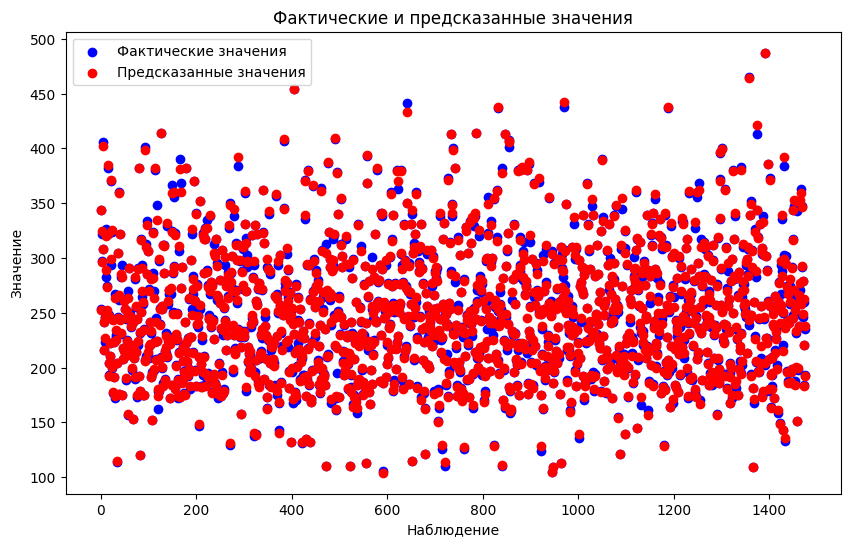

C:\Users\Alwx\AppData\Local\Temp\ipykernel_13128\2431479552.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


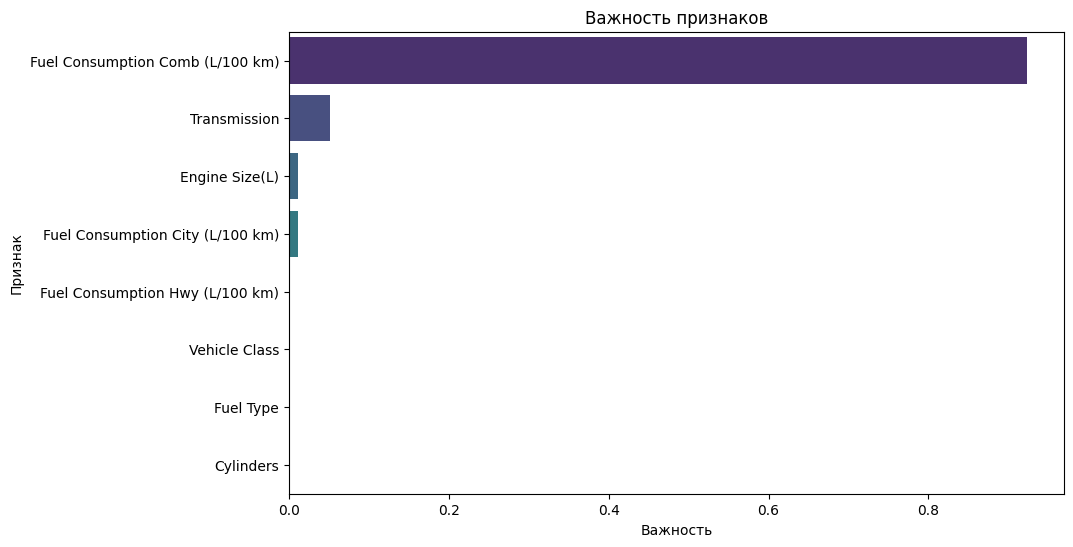

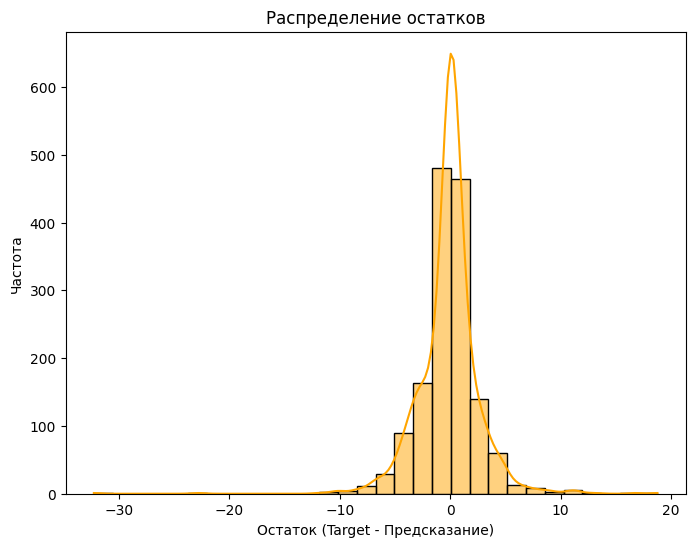

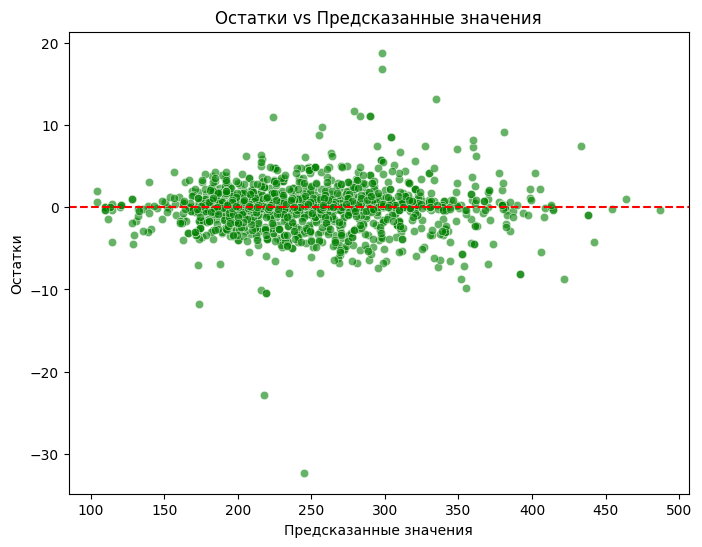

In [242]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели Gradient Boosting Regressor
rfr = RandomForestRegressor() # параметры
rfr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr.predict(X_test)

# Вычисление метрик
rfr_metrics = getMetrics(y_test, y_pred)

# Важность признаков
getImportances(rfr.feature_importances_)

getRemains(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 2.4831141392
MSE: 11.2208121118
RMSE: 3.3497480669
R²: 0.9967377827


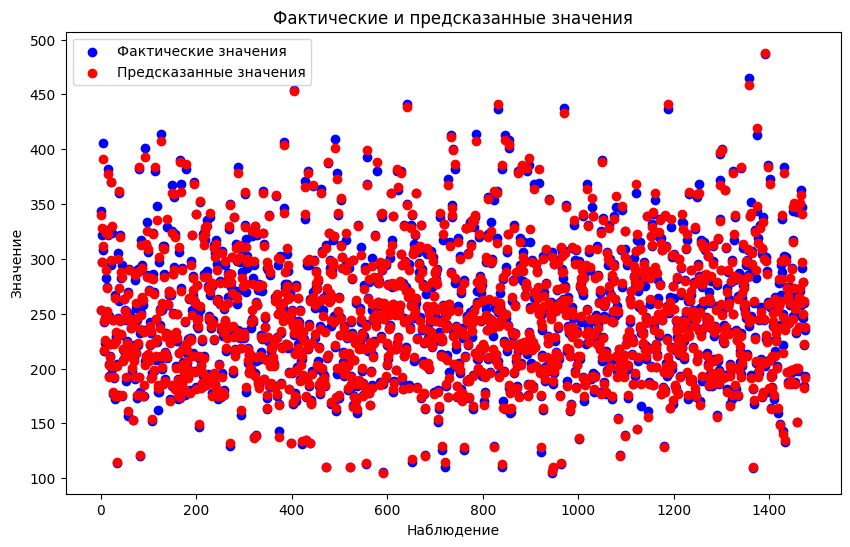

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() # параметры
gbr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = gbr.predict(X_test)

# Вычисление метрик
gbr_metrics = getMetrics(y_test, y_pred)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 5908, number of used features: 8
[LightGBM] [Info] Start training from score 250.939573
*****************
Метрики качества:
*****************
MAE: 2.1814265590
MSE: 10.2891640133
RMSE: 3.2076726786
R²: 0.9970086400


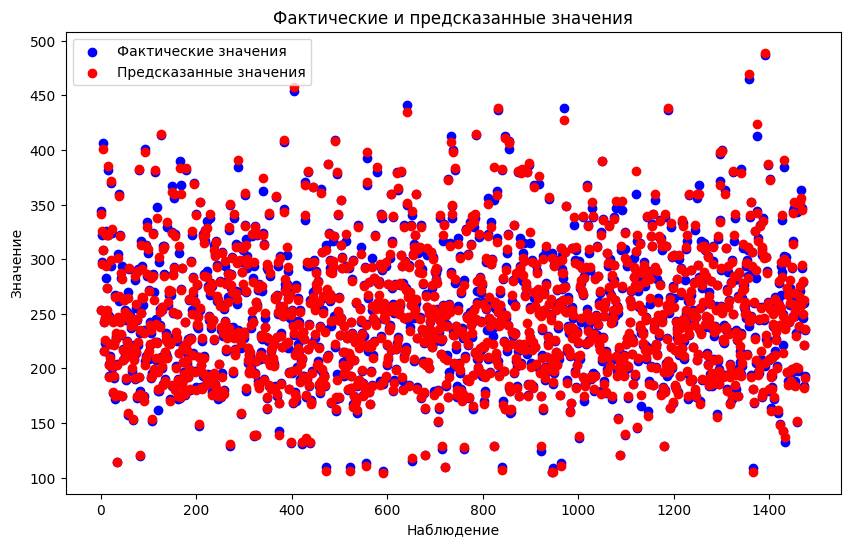

In [244]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 1.8705270311
MSE: 8.2658872501
RMSE: 2.8750456083
R²: 0.9975968599


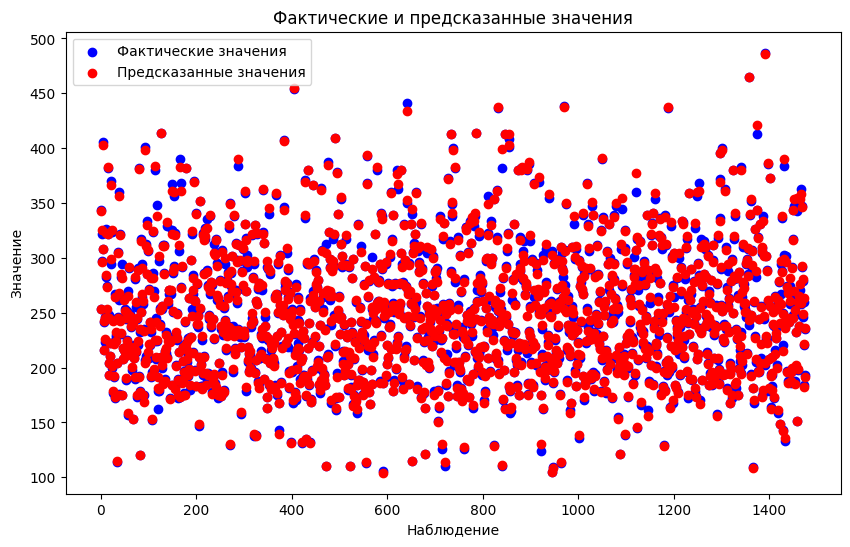

In [245]:
from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
lgbm_metrics = getMetrics(y_test, y_pred)

C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 500}
*****************
Метрики качества:
*****************
MAE: 11.0141636544
MSE: 396.2333850173
RMSE: 19.9056118976
R²: 0.8848033995


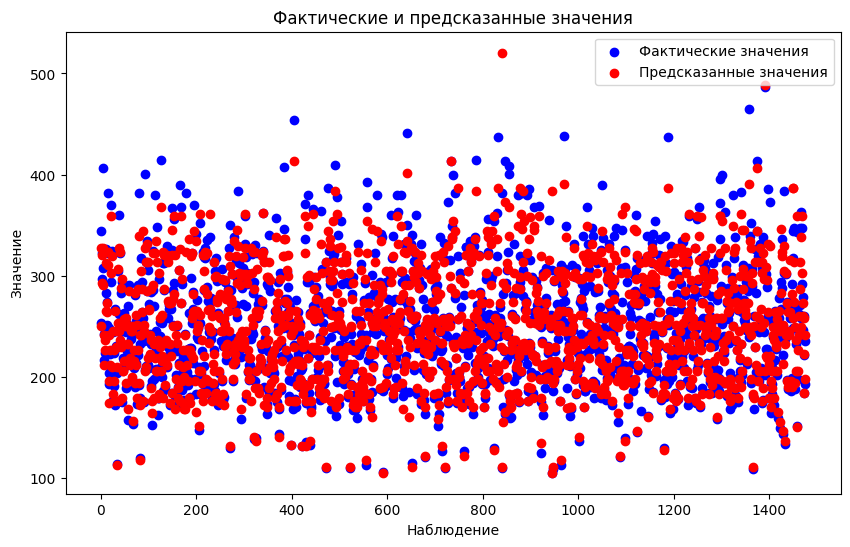

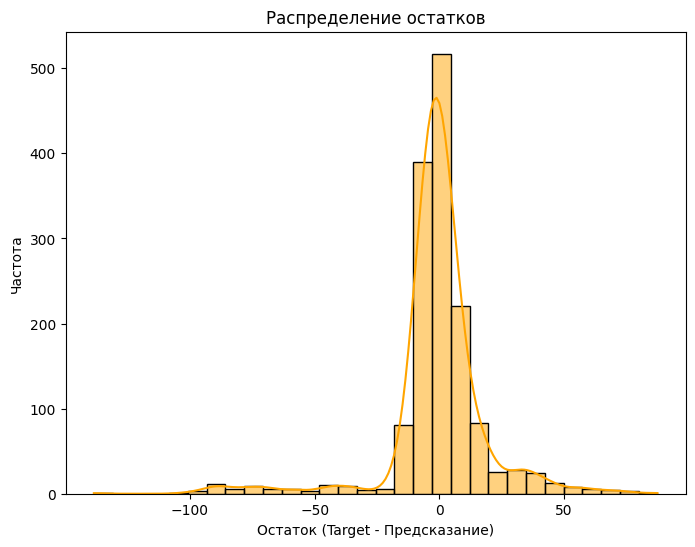

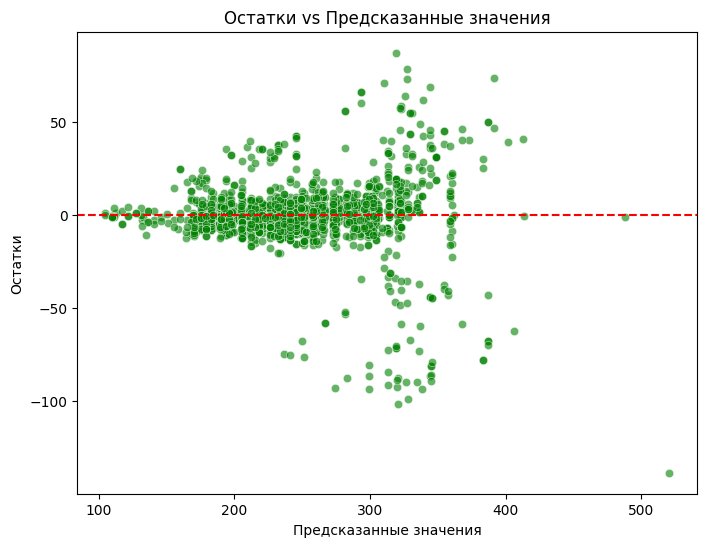

In [250]:
from sklearn.model_selection import GridSearchCV

X = numdata[['Fuel Consumption City (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = getMetrics(y_test, y_pred)

getRemains(y_test, y_pred)

C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Alwx\Desktop\PythonProjects\Homework5\hw5_venv\lib\site-packages\sklearn\

Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 200}
*****************
Метрики качества:
*****************
MAE: 26.0508283933
MSE: 1273.2441812206
RMSE: 35.6825472916
R²: 0.6298307846


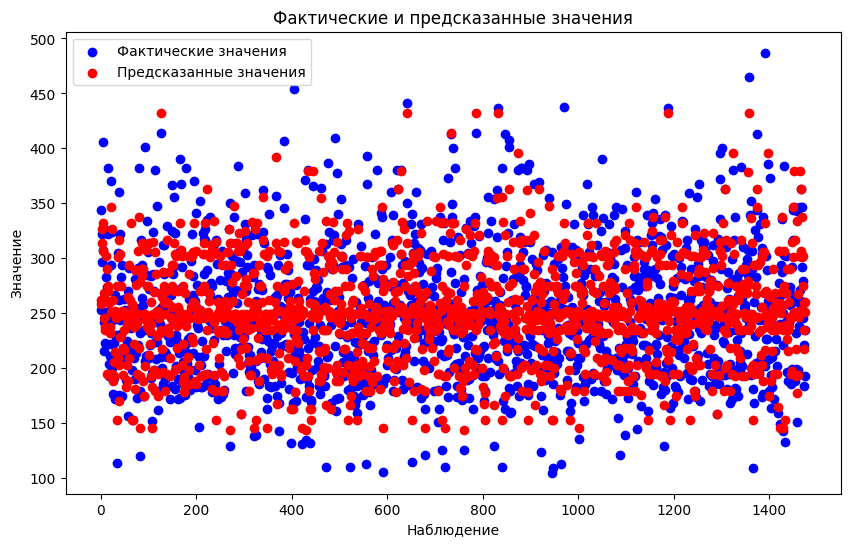

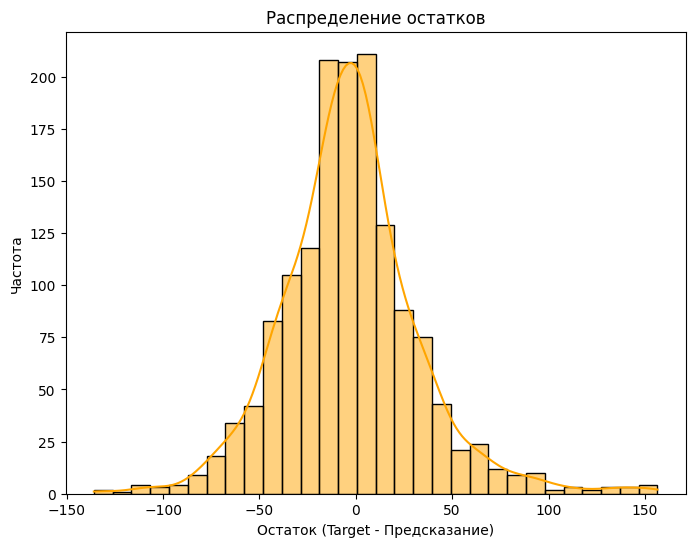

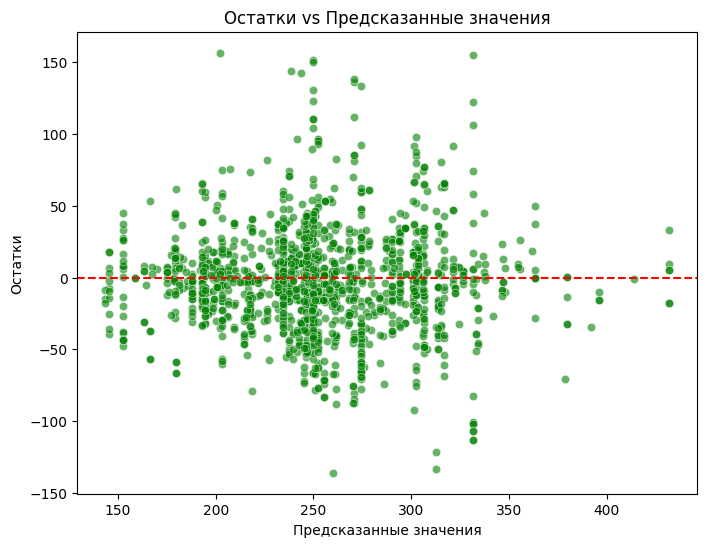

In [253]:
X = pd.DataFrame()
X['Vehicle Class'] = encoded_vehicle_class
X['Transmission'] = encoded_fuel_type
X['Fuel Type'] = encoded_transmission

y = numdata[['CO2 Emissions(g/km)']].values.ravel()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Создание и обучение модели Gradient Boosting Regressor
rfr_1 = RandomForestRegressor(**best_params) # параметры
rfr_1.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = getMetrics(y_test, y_pred)

getRemains(y_test, y_pred)